# import + dataset load

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.data_cleaning import clean_dataset

PATH = "datasets/employee-churn/churn.csv"
dataset = pd.read_csv(PATH)
dataset = clean_dataset(dataset)

# separate loyal employees from the others

## correlation between numeric column

In [2]:
dataset.corr(numeric_only=True).style.background_gradient(cmap="RdBu", vmin=-1, vmax=1)

,enrollee_id,city_development_index,relevent_experience,education_level,experience,company_size,last_new_job,training_hours,target
enrollee_id,1.000000,-0.040455,-0.043359,-0.017848,-0.034695,0.007414,-0.024552,0.000998,0.049475
city_development_index,-0.040455,1.000000,0.059808,0.043123,0.334238,0.081532,0.195289,0.001920,-0.341665
relevent_experience,-0.043359,0.059808,1.000000,0.237202,0.338764,0.118460,0.250279,0.011566,-0.128430
education_level,-0.017848,0.043123,0.237202,1.000000,0.256990,0.136709,0.198297,-0.013742,-0.004372
experience,-0.034695,0.334238,0.338764,0.256990,1.000000,0.117705,0.480192,0.000369,-0.176898
company_size,0.007414,0.081532,0.118460,0.136709,0.117705,1.000000,0.136925,-0.007131,-0.084715
last_new_job,-0.024552,0.195289,0.250279,0.198297,0.480192,0.136925,1.000000,-0.003669,-0.087113
training_hours,0.000998,0.001920,0.011566,-0.013742,0.000369,-0.007131,-0.003669,1.000000,-0.021577
target,0.049475,-0.341665,-0.128430,-0.004372,-0.176898,-0.084715,-0.087113,-0.021577,1.000000


### conclusion

The result are inconclusive, there is no strong correlation between any on the columns with the target column.

## using feature_importance from an ML model

### imports

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)

In [4]:
def plot_feature_importance(f, columns):
    f = pd.DataFrame({"Features": columns, "Importance Score": f})
    f = f.sort_values(by="Importance Score", ascending=False)
    print(f.head())
    # plot from most to least important
    f.head(10)[::-1].plot(
        x="Features",
        y="Importance Score",
        kind="barh",
        color="blue",
        edgecolor="k",
        title="Feature Importance",
    )


def get_X_y(dataset: pd.DataFrame):
    data = dataset.copy()

    X = data.drop(columns=["enrollee_id", "target"])
    y = data["target"]

    return X, y


def classification_eval(*, y_pred, y_test):
    display_labels = ["Not looking", "Looking"]

    # Evaluate the model
    classification_rep = classification_report(y_test, y_pred, target_names=display_labels)
    print("Classification Report:\n", classification_rep)

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=display_labels)

### exclude categorical columns

                 Features  Importance Score
6          training_hours          0.319266
0  city_development_index          0.274354
3              experience          0.145855
4            company_size          0.118265
5            last_new_job          0.064153
Classification Report:
               precision    recall  f1-score   support

 Not looking       0.83      0.89      0.86      2880
     Looking       0.57      0.47      0.52       952

    accuracy                           0.78      3832
   macro avg       0.70      0.68      0.69      3832
weighted avg       0.77      0.78      0.77      3832



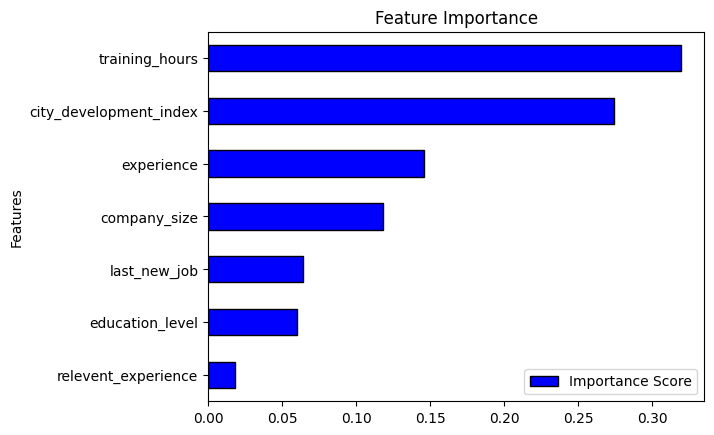

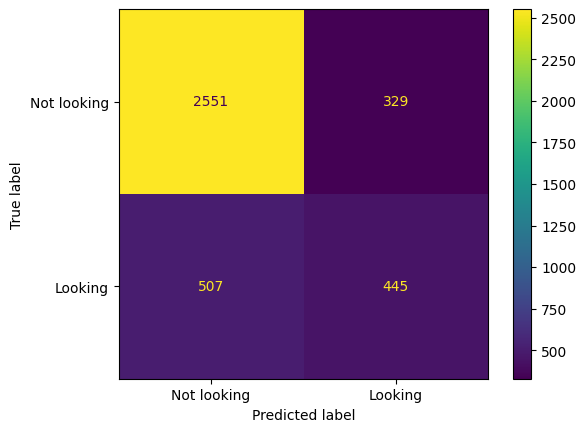

In [5]:
X, y = get_X_y(dataset)

categorical_cols = ["city", "gender", "enrolled_university", "major_discipline", "company_type"]
X.drop(categorical_cols, axis=1, inplace=True)

# split the data into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

plot_feature_importance(model.feature_importances_, X.columns)

classification_eval(
    y_test=y_test,
    y_pred=model.predict(X_test),
)

### include categorical columns

by converting them with `get_dummies`

                 Features  Importance Score
6          training_hours          0.200349
3              experience          0.130370
0  city_development_index          0.111853
4            company_size          0.089225
5            last_new_job          0.064837
Classification Report:
               precision    recall  f1-score   support

 Not looking       0.83      0.88      0.86      2880
     Looking       0.56      0.46      0.50       952

    accuracy                           0.78      3832
   macro avg       0.70      0.67      0.68      3832
weighted avg       0.76      0.78      0.77      3832



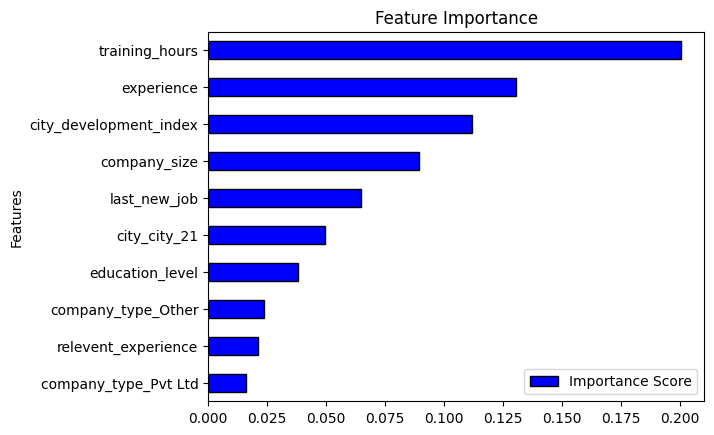

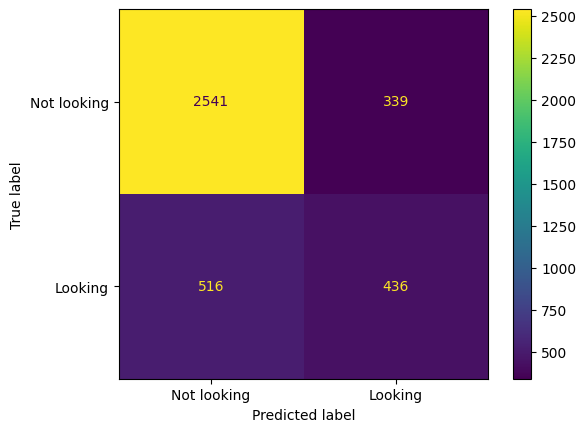

In [6]:
X, y = get_X_y(dataset)

X = pd.get_dummies(X, columns=categorical_cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

plot_feature_importance(model.feature_importances_, X.columns)

classification_eval(
    y_test=y_test,
    y_pred=model.predict(X_test),
)

### use categorical column but use something to reduce the number of feautures

old shape: (19158, 150), new shape: (19158, 10)
                 Features  Importance Score
0  city_development_index          0.472703
2              experience          0.276199
5            city_city_21          0.080013
8      company_type_Other          0.069980
9    company_type_Pvt Ltd          0.029893
Classification Report:
               precision    recall  f1-score   support

 Not looking       0.83      0.85      0.84      2880
     Looking       0.50      0.46      0.48       952

    accuracy                           0.75      3832
   macro avg       0.66      0.65      0.66      3832
weighted avg       0.75      0.75      0.75      3832



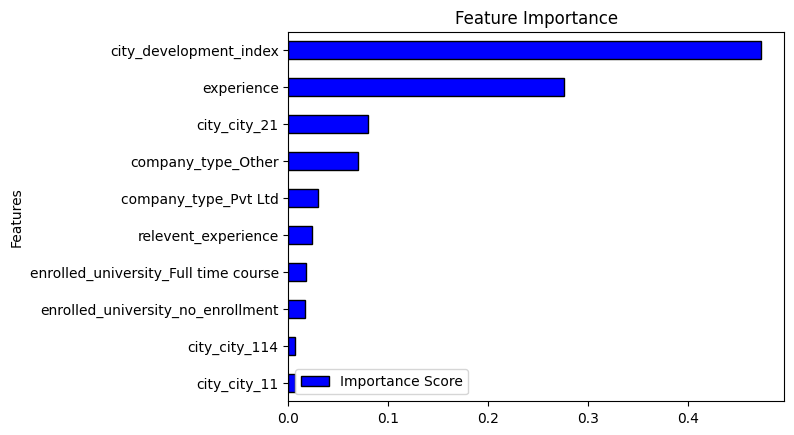

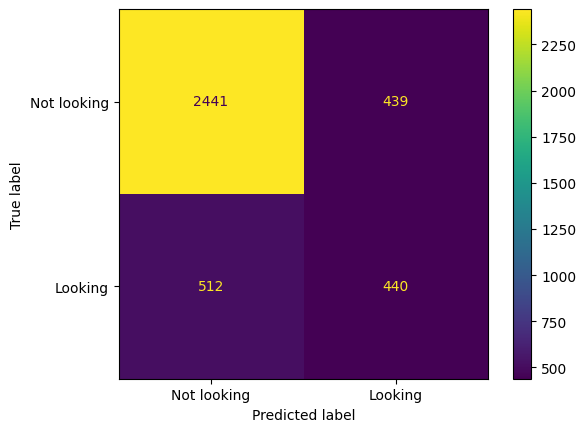

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X, y = get_X_y(dataset)

k_best = SelectKBest(f_classif, k=10)

X = pd.get_dummies(X, columns=categorical_cols)

# select only the best features
X_new = k_best.fit_transform(X, y)
new_features_names = X.columns[k_best.get_support()]
print(f"old shape: {X.shape}, new shape: {X_new.shape}")

X = pd.DataFrame(X_new, columns=new_features_names, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

plot_feature_importance(model.feature_importances_, new_features_names)

classification_eval(
    y_test=y_test,
    y_pred=model.predict(X_test),
)

### Use some tecnique to balance the dataset

#### use `RandomOverSampler`

old shape: (19158, 150), new shape: (19158, 10)
                 Features  Importance Score
0  city_development_index          0.470124
2              experience          0.250249
8      company_type_Other          0.093630
5            city_city_21          0.070923
9    company_type_Pvt Ltd          0.045349
Classification Report:
               precision    recall  f1-score   support

 Not looking       0.82      0.73      0.78      2877
     Looking       0.76      0.84      0.80      2876

    accuracy                           0.79      5753
   macro avg       0.79      0.79      0.79      5753
weighted avg       0.79      0.79      0.79      5753



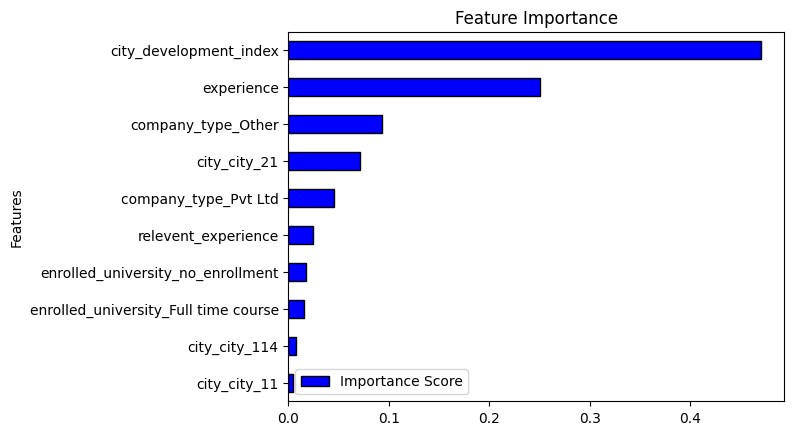

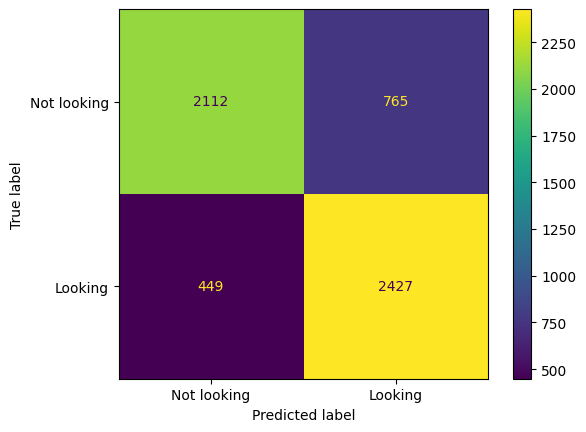

In [13]:
from imblearn.over_sampling import RandomOverSampler

X, y = get_X_y(dataset)

k_best = SelectKBest(f_classif, k=10)

X = pd.get_dummies(X, columns=categorical_cols)

# select only the best features
X_new = k_best.fit_transform(X, y)
new_features_names = X.columns[k_best.get_support()]
print(f"old shape: {X.shape}, new shape: {X_new.shape}")

X = pd.DataFrame(X_new, columns=new_features_names, index=X.index)

ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

plot_feature_importance(model.feature_importances_, new_features_names)

classification_eval(
    y_test=y_test,
    y_pred=model.predict(X_test),
)

#### use `ClusterCentroids`

old shape: (19158, 150), new shape: (19158, 10)
                 Features  Importance Score
0  city_development_index          0.457909
2              experience          0.267119
8      company_type_Other          0.083320
5            city_city_21          0.069981
9    company_type_Pvt Ltd          0.047083
Classification Report:
               precision    recall  f1-score   support

 Not looking       0.71      0.71      0.71       967
     Looking       0.71      0.71      0.71       944

    accuracy                           0.71      1911
   macro avg       0.71      0.71      0.71      1911
weighted avg       0.71      0.71      0.71      1911



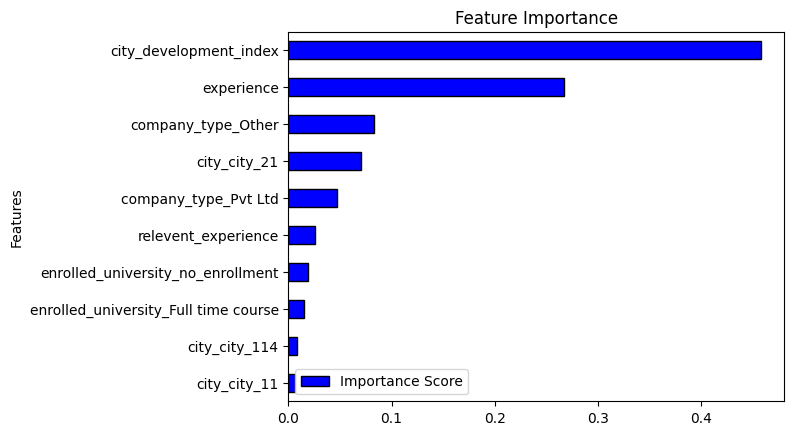

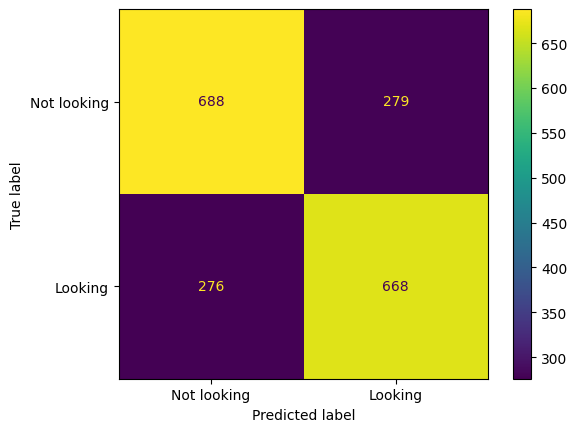

In [15]:
from imblearn.under_sampling import RandomUnderSampler

X, y = get_X_y(dataset)

k_best = SelectKBest(f_classif, k=10)

X = pd.get_dummies(X, columns=categorical_cols)

# select only the best features
X_new = k_best.fit_transform(X, y)
new_features_names = X.columns[k_best.get_support()]
print(f"old shape: {X.shape}, new shape: {X_new.shape}")

X = pd.DataFrame(X_new, columns=new_features_names, index=X.index)

cc = RandomUnderSampler(random_state=42)
X, y = cc.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

plot_feature_importance(model.feature_importances_, new_features_names)

classification_eval(
    y_test=y_test,
    y_pred=model.predict(X_test),
)